In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [52]:
df_baseline = pd.read_csv('baseline/summary.csv')
df_rewrite = pd.read_csv('rewrite/summary.csv')
keys = [
    'lut_used',
    'bram_used',
    'dsp_used',
    'reg_used',
    'lutmem_used',
    'uram_used'
]
benchmarks = set([
    "aes", "backprop", "bfs-bulk", "bfs-queue", "fft-strided", "fft-transpose", "gemm-blocked", "gemm-ncubed", "kmp", "md-grid", "md-knn", 
    "nw", "sort-merge", "sort-radix", "spmv-crs", "spmv-ellpack", "stencil-stencil2d", "stencil-stencil3d", "viterbi"
])

In [18]:
df_rewrite

,status,bench,bram_used,dsp_used,lut_used,lutmem_used,reg_used,uram_used,type
0,ok,bfs-bulk,2,0,2512,133,4577,0,rewrite
1,ok,sort-merge,5,0,2165,151,2931,0,rewrite
2,ok,md-grid,8,41,10989,499,19648,0,rewrite
3,ok,stencil-stencil2d,1,27,2446,115,4102,0,rewrite
4,ok,bfs-queue,3,0,2553,135,4261,0,rewrite
5,ok,sort-radix,1,0,2777,122,4022,0,rewrite
6,ok,gemm-blocked,2,11,2288,220,4836,0,rewrite
7,ok,spmv-ellpack,2,11,2432,220,4911,0,rewrite
8,ok,nw,1,0,4090,122,5976,0,rewrite
9,ok,fft-strided,2,38,4311,437,8396,0,rewrite


In [4]:
def cleanup(df):
    # Remove prefix:machuite- from benchmark names
    df.bench = df.bench.apply(lambda row: row.split(':')[1].replace('machsuite-', ''))
    # Remove benchmarks with status != 'ok' 
    df = df[df.status == 'ok']

    return df

df_baseline = cleanup(df_baseline)
df_rewrite = cleanup(df_rewrite)
# Coerce columns to right types
df_baseline[keys] = df_baseline[keys].apply(pd.to_numeric)
df_rewrite[keys] = df_rewrite[keys].apply(pd.to_numeric)

In [5]:
# Find sets of missing benchmarks
baseline_missing = benchmarks.difference(set(df_baseline['bench']))
rewrite_missing = set(df_baseline.bench).difference(set(df_rewrite.bench))

In [6]:
df_baseline['type'] = 'baseline'
df_rewrite['type'] = 'rewrite'
df = pd.concat([df_baseline, df_rewrite], ignore_index=True, sort=False)

In [7]:
for key in keys:
    df[key] = pd.to_numeric(df[key], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
status         32 non-null object
uram_used      32 non-null int64
dsp_used       32 non-null int64
bram_used      32 non-null int64
lut_used       32 non-null int64
lutmem_used    32 non-null int64
reg_used       32 non-null int64
bench          32 non-null object
type           32 non-null object
dtypes: int64(6), object(3)
memory usage: 2.4+ KB


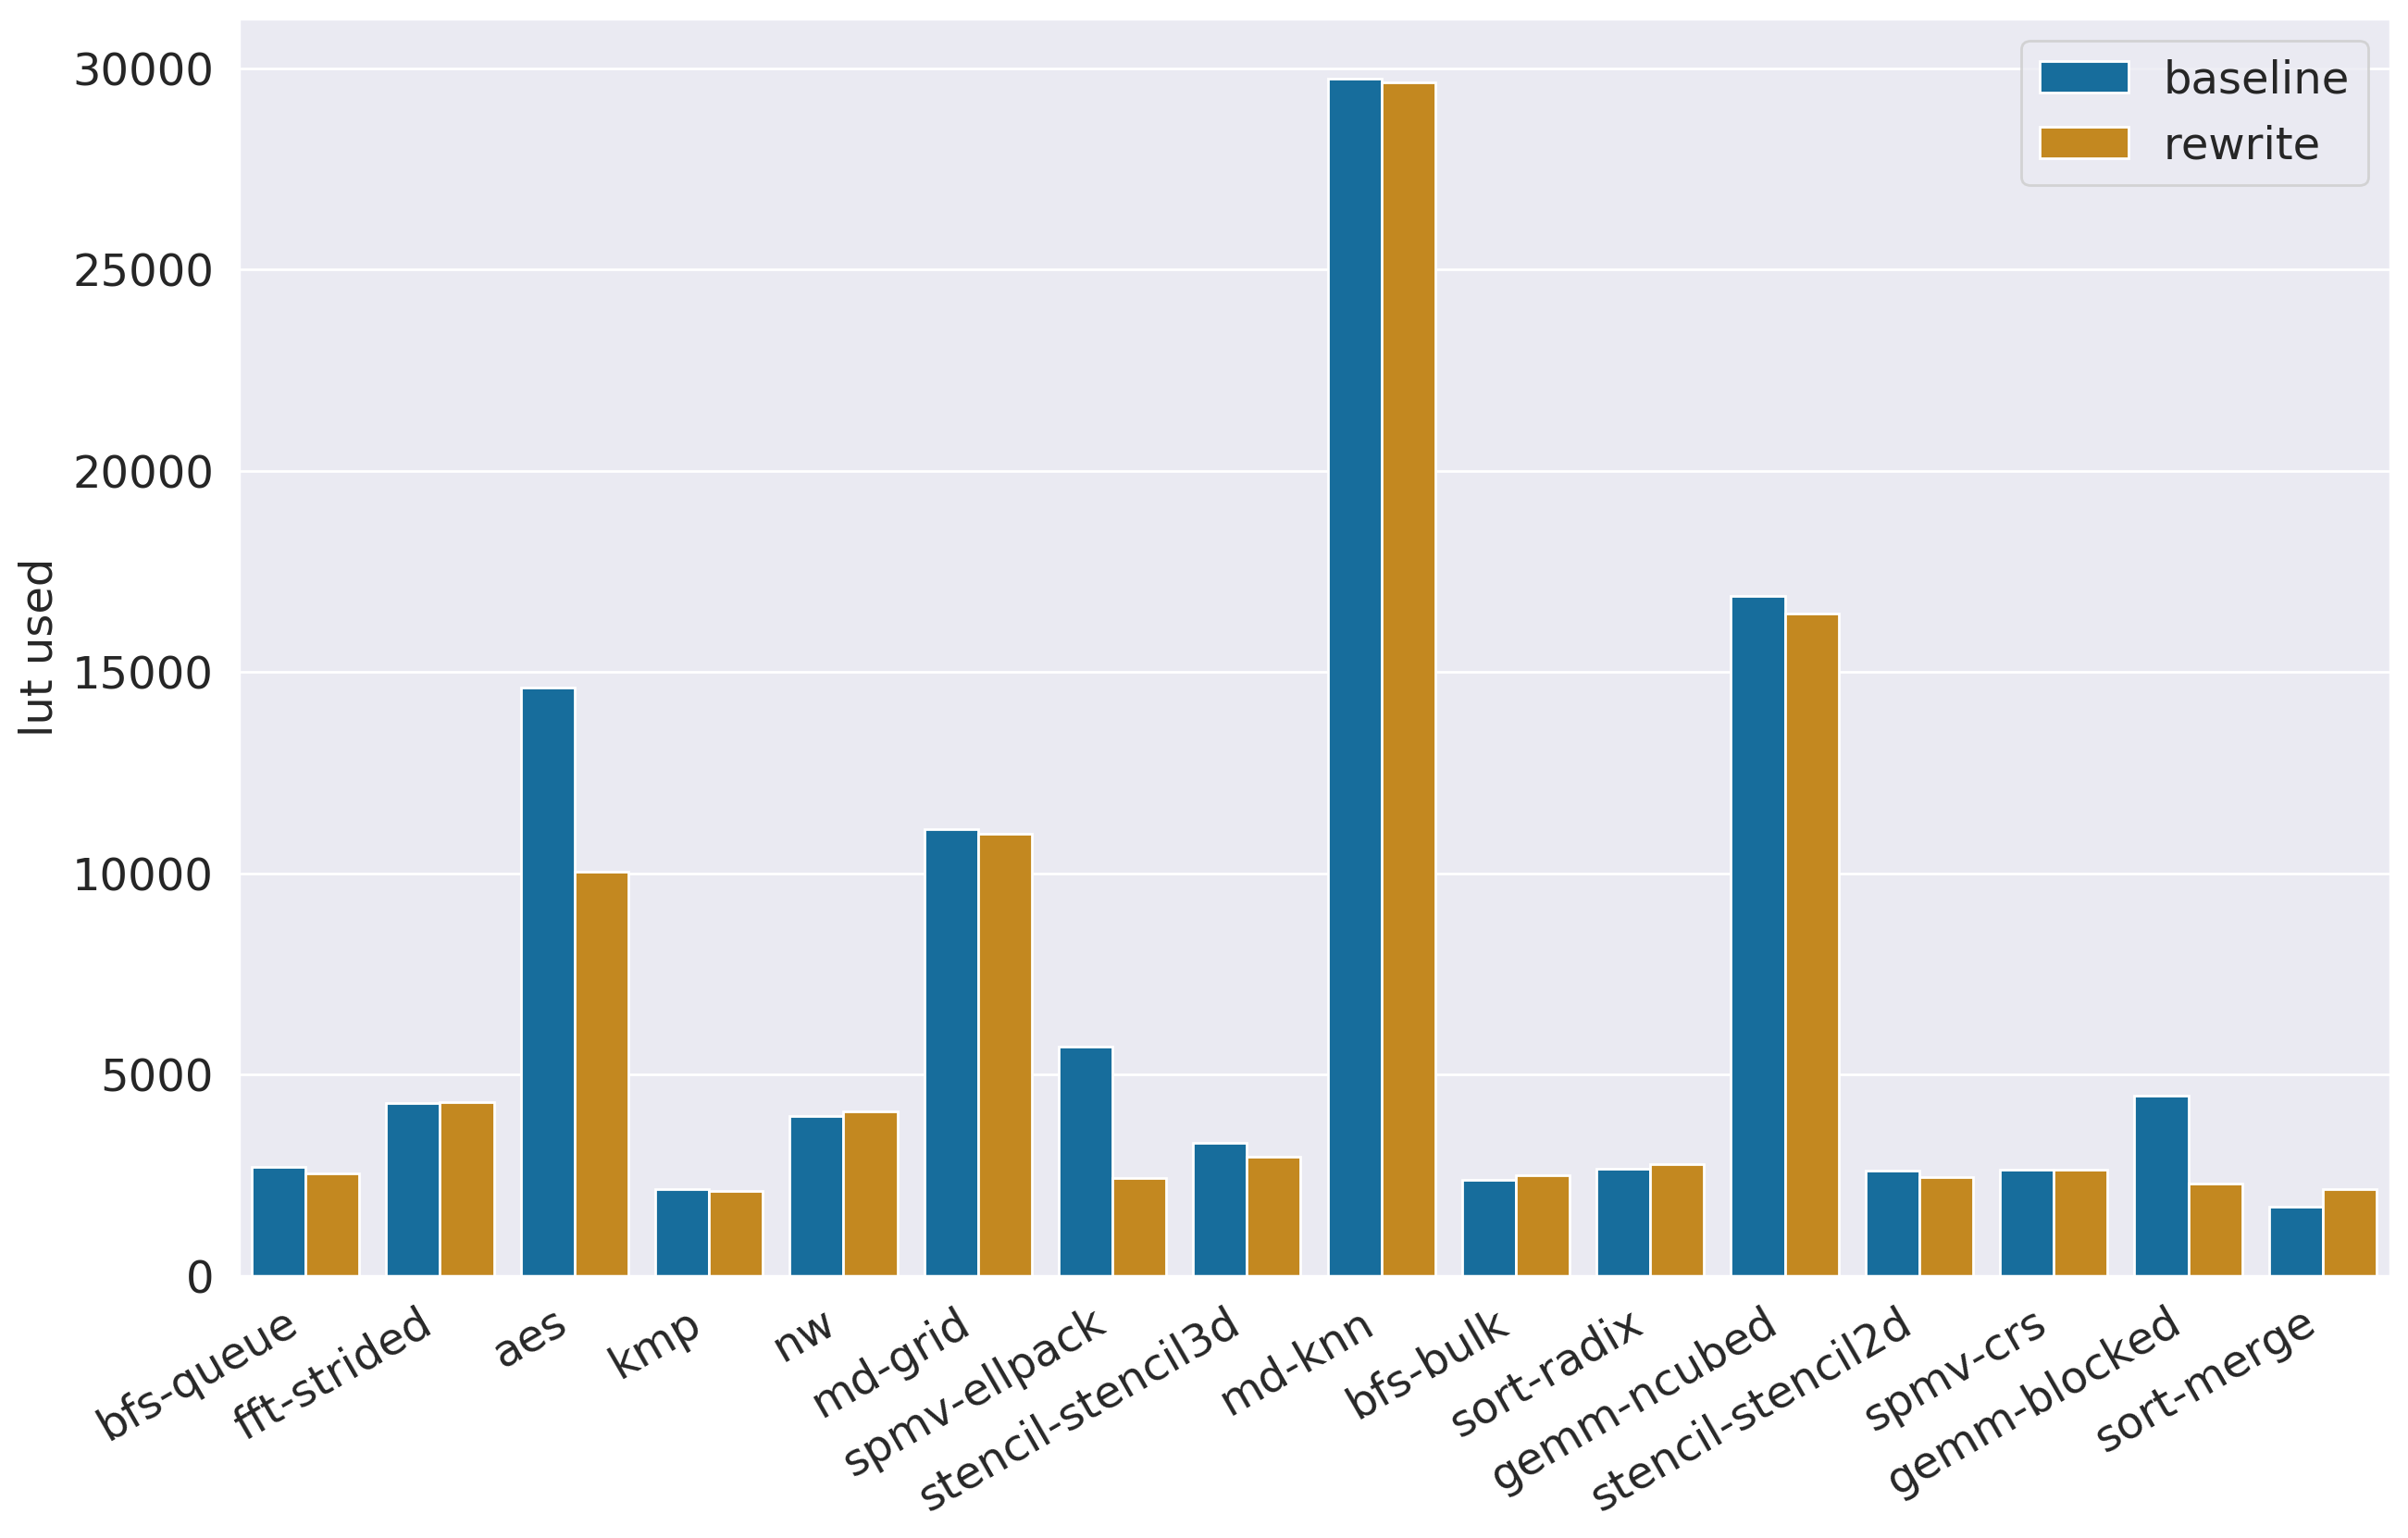

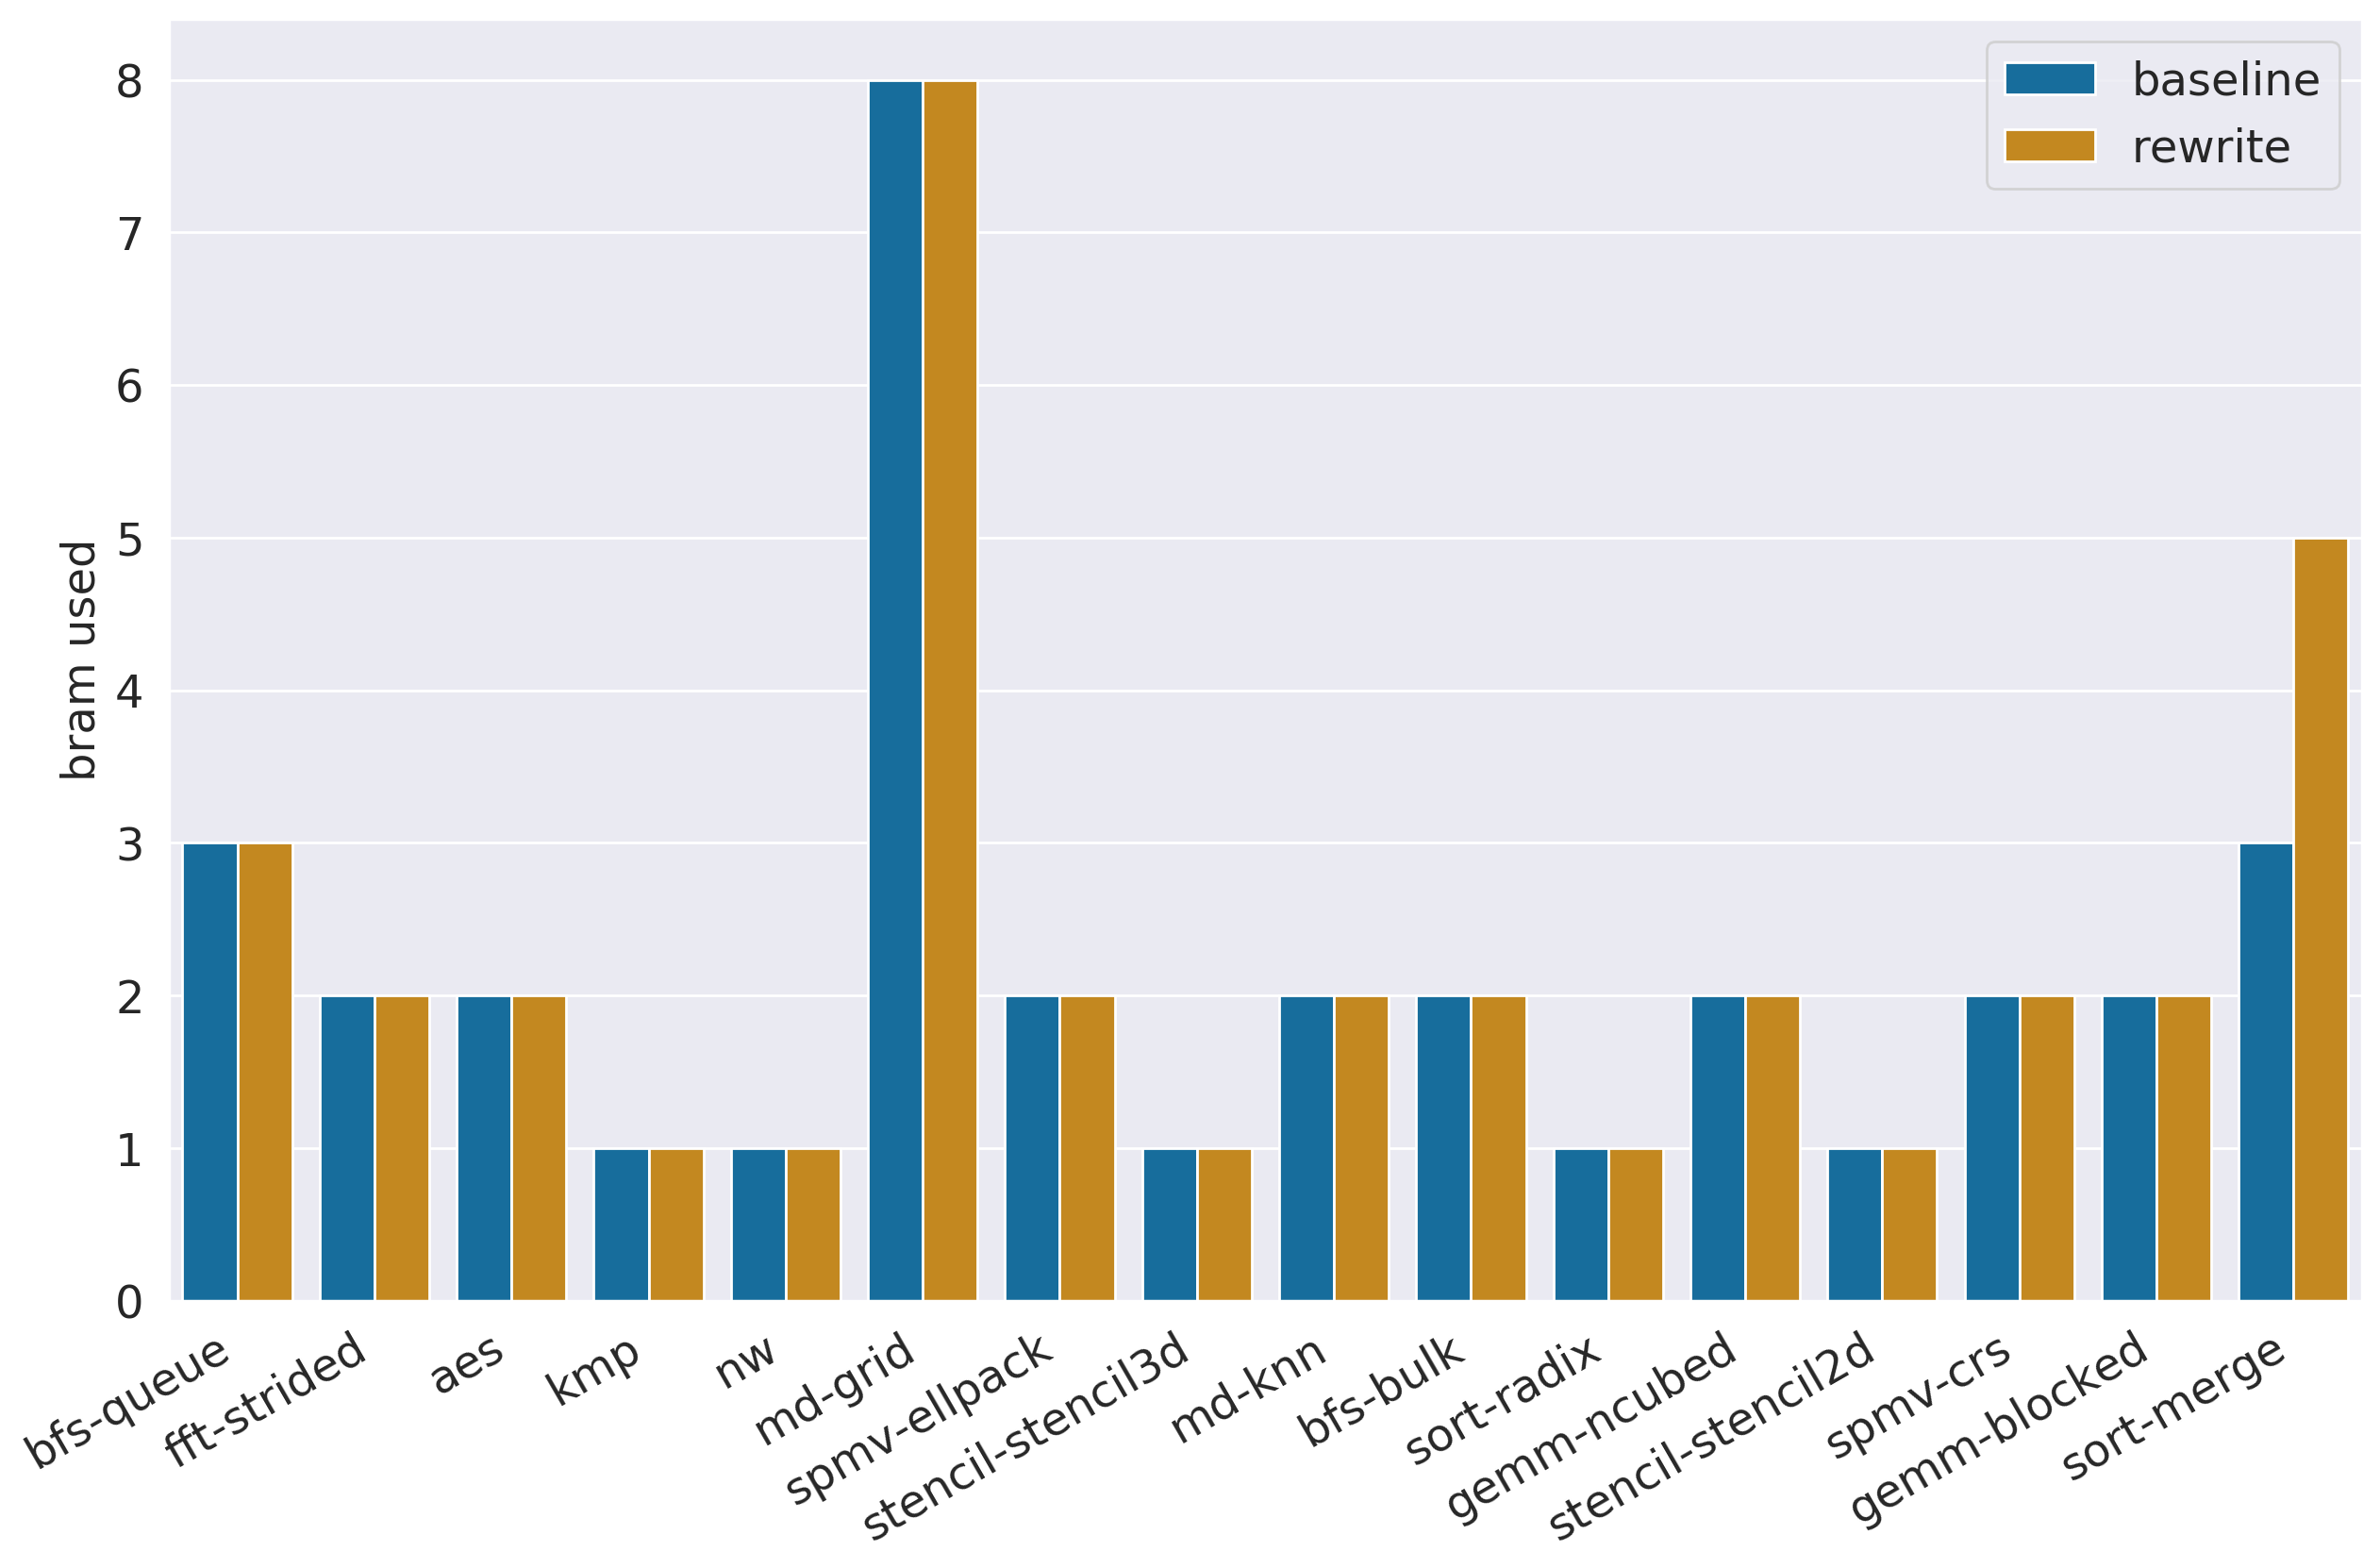

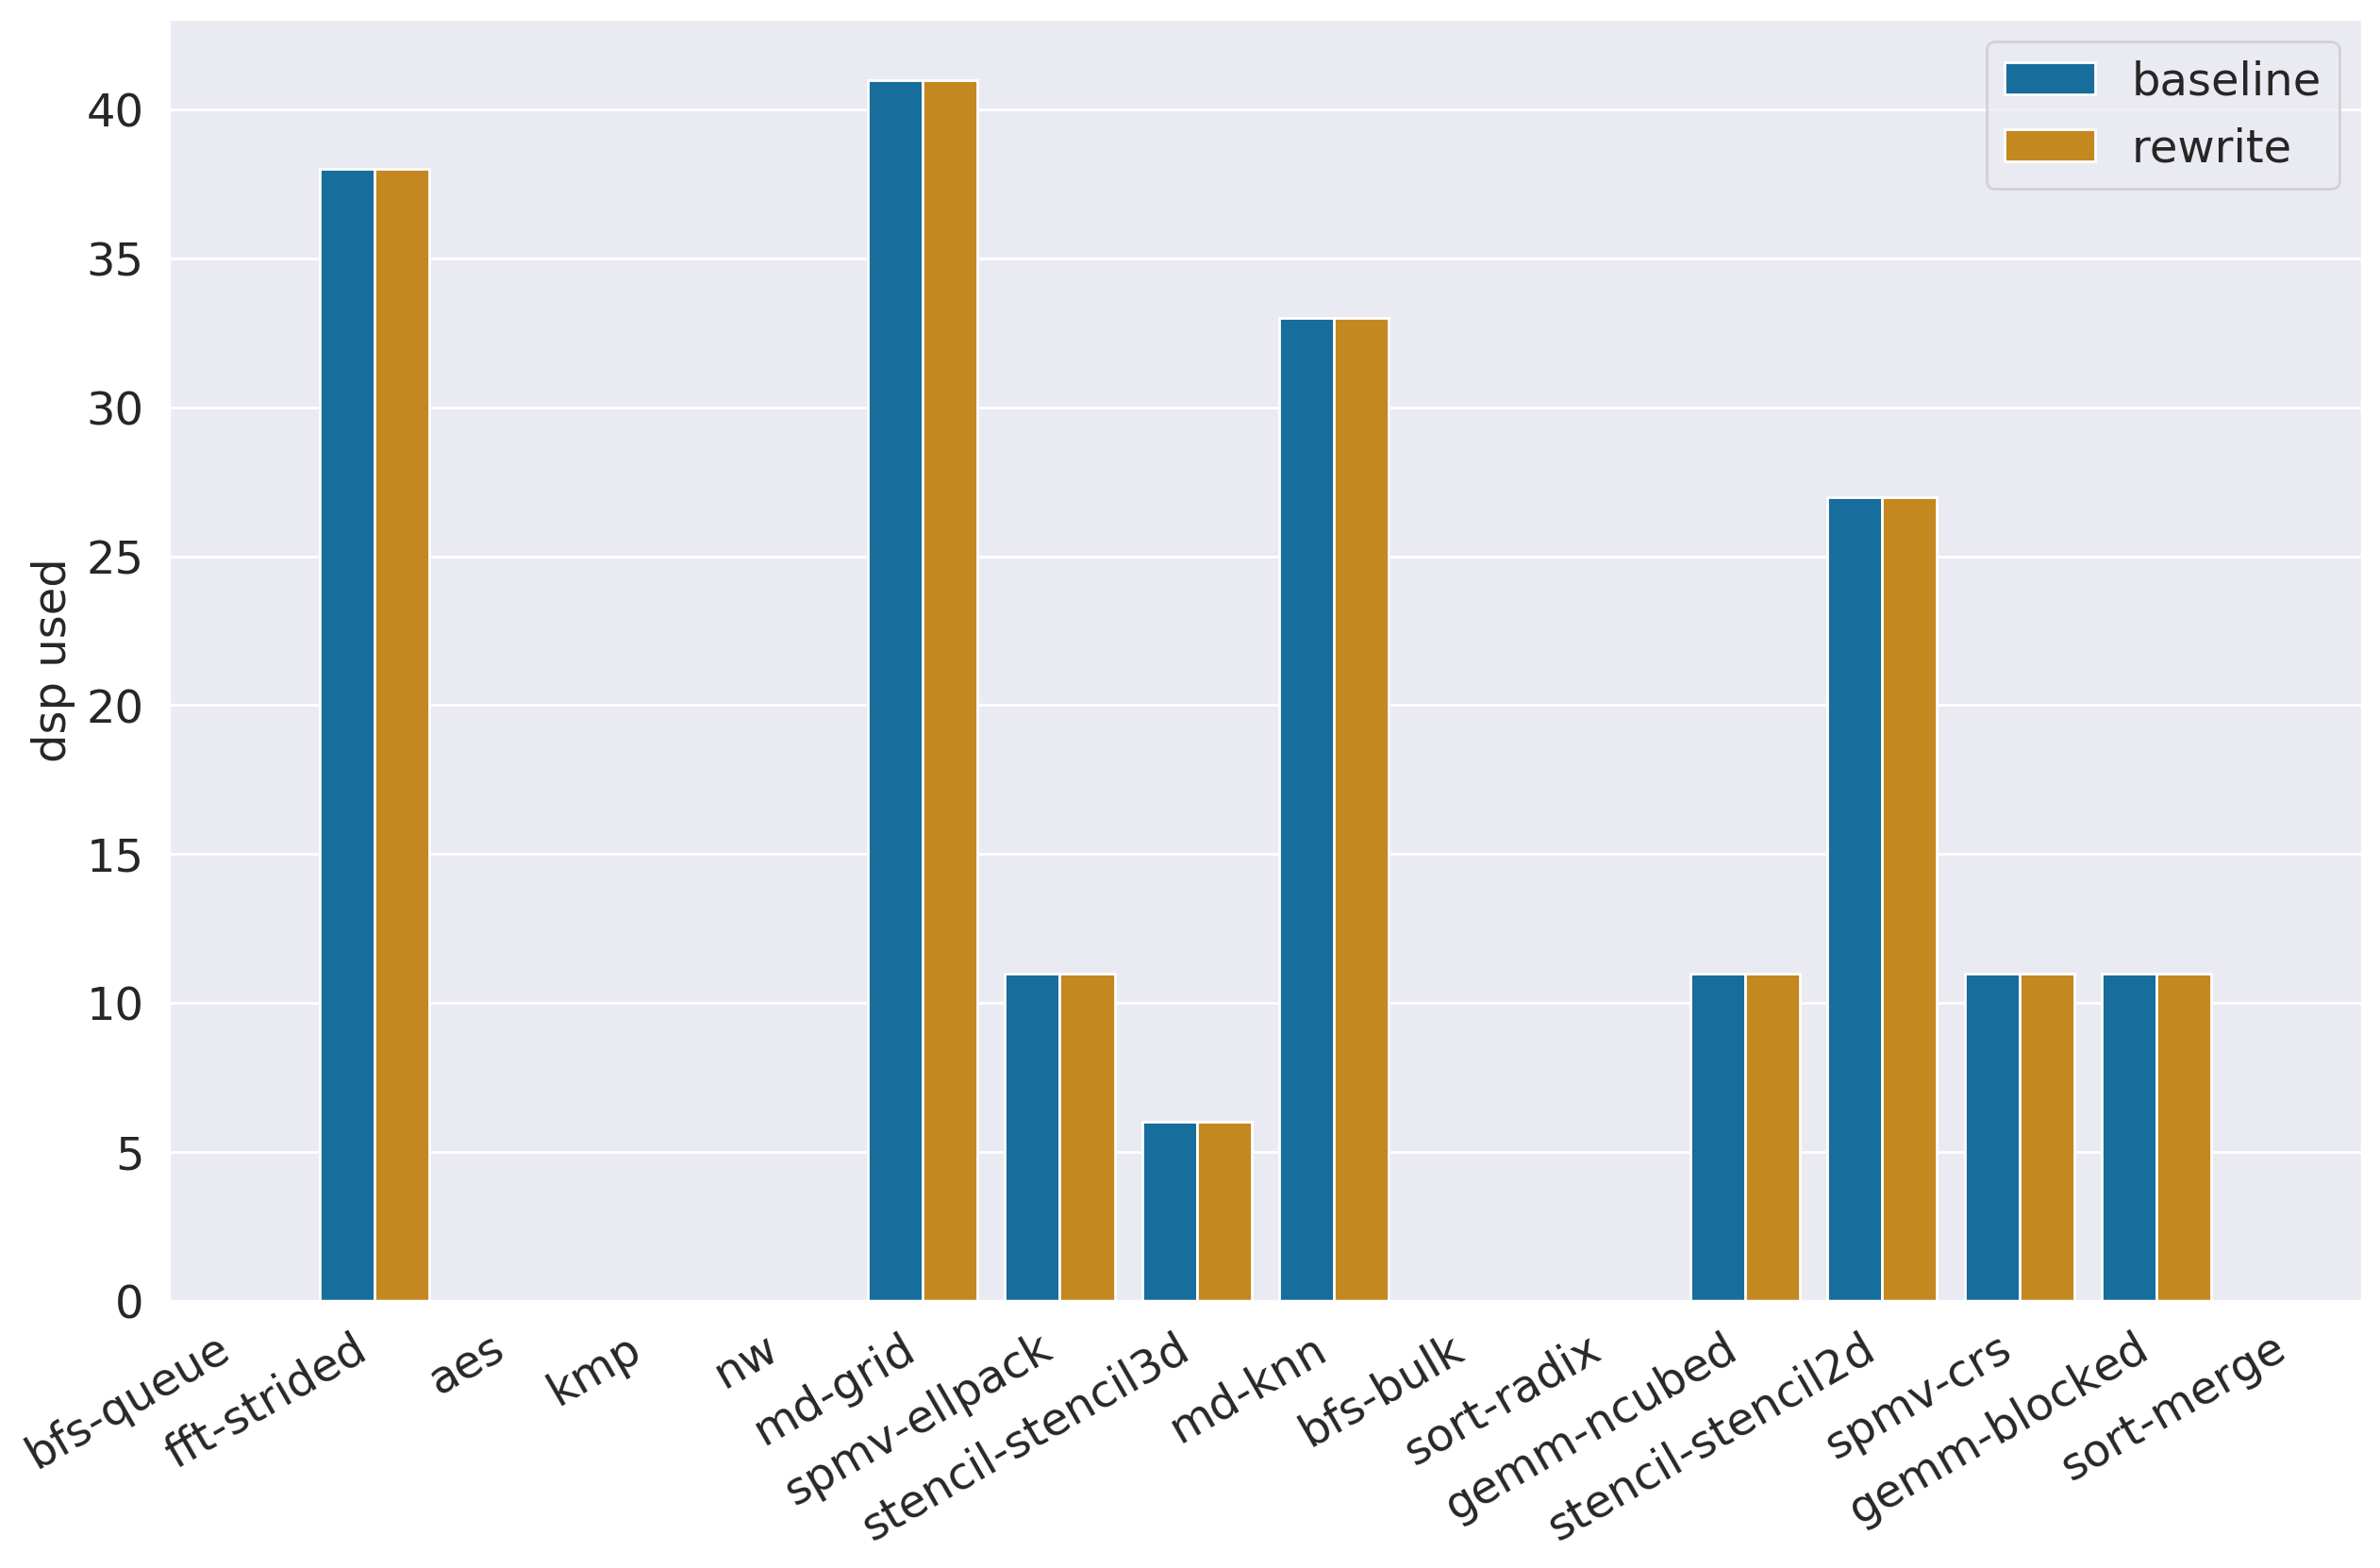

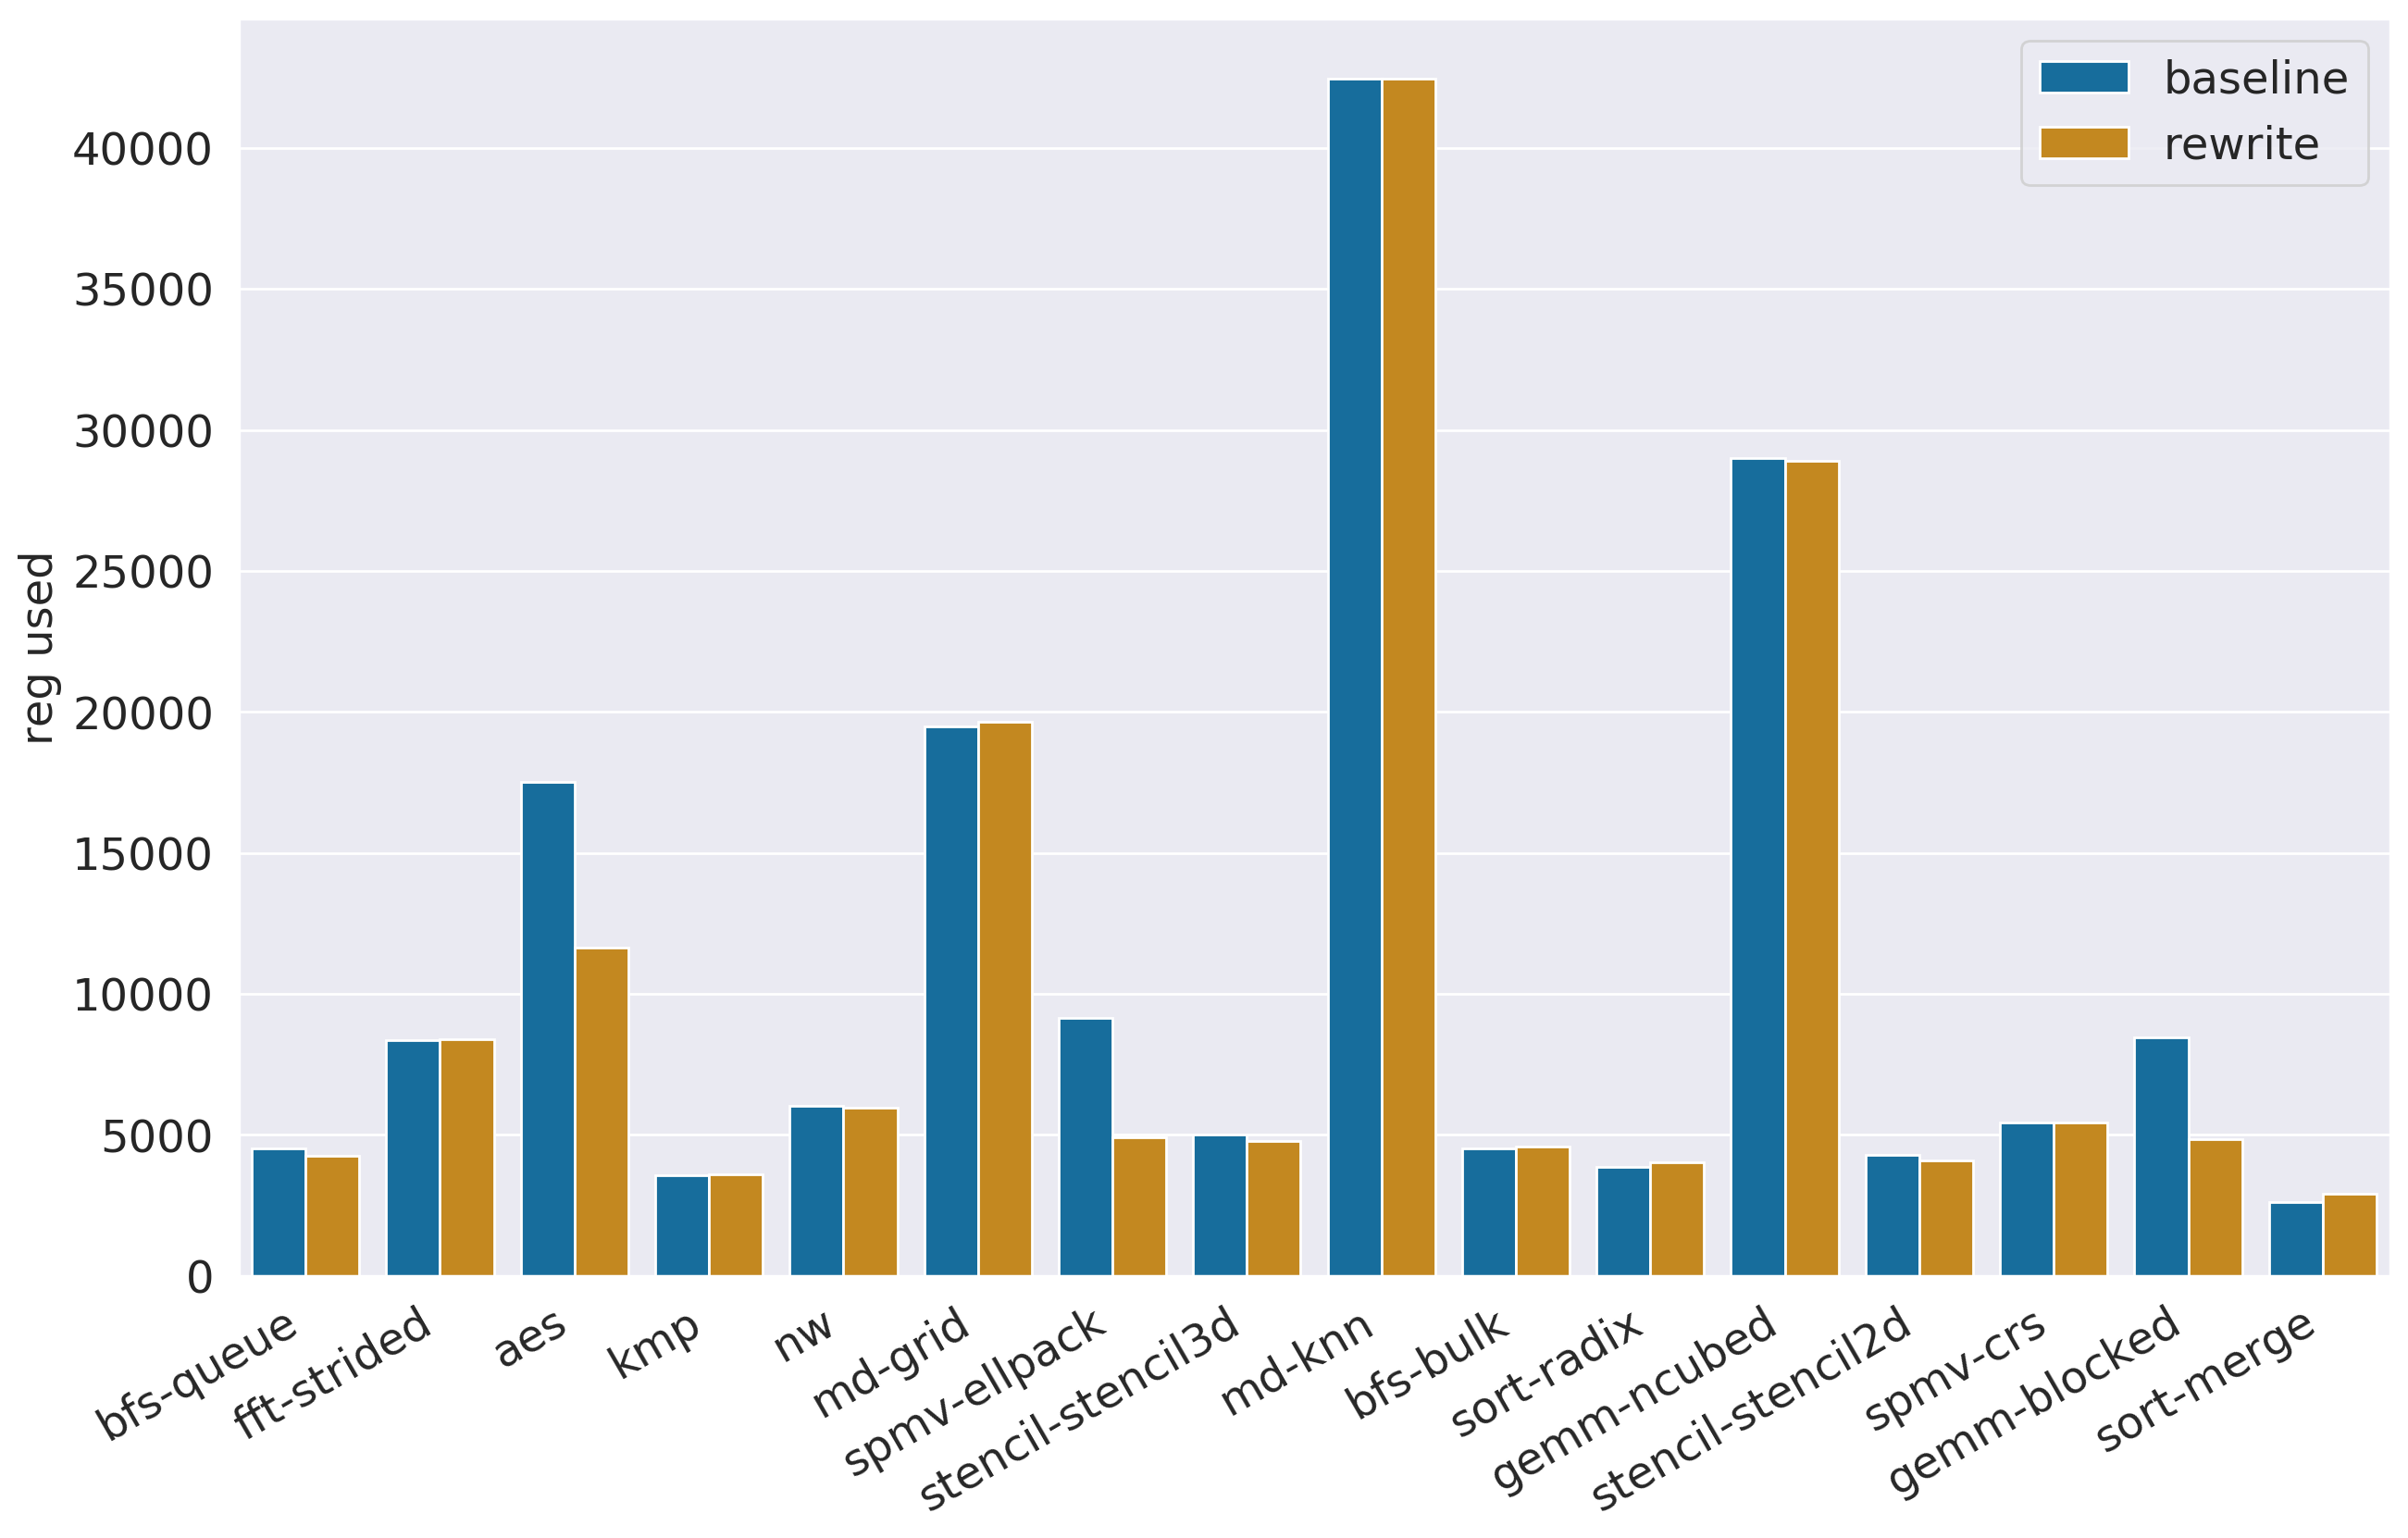

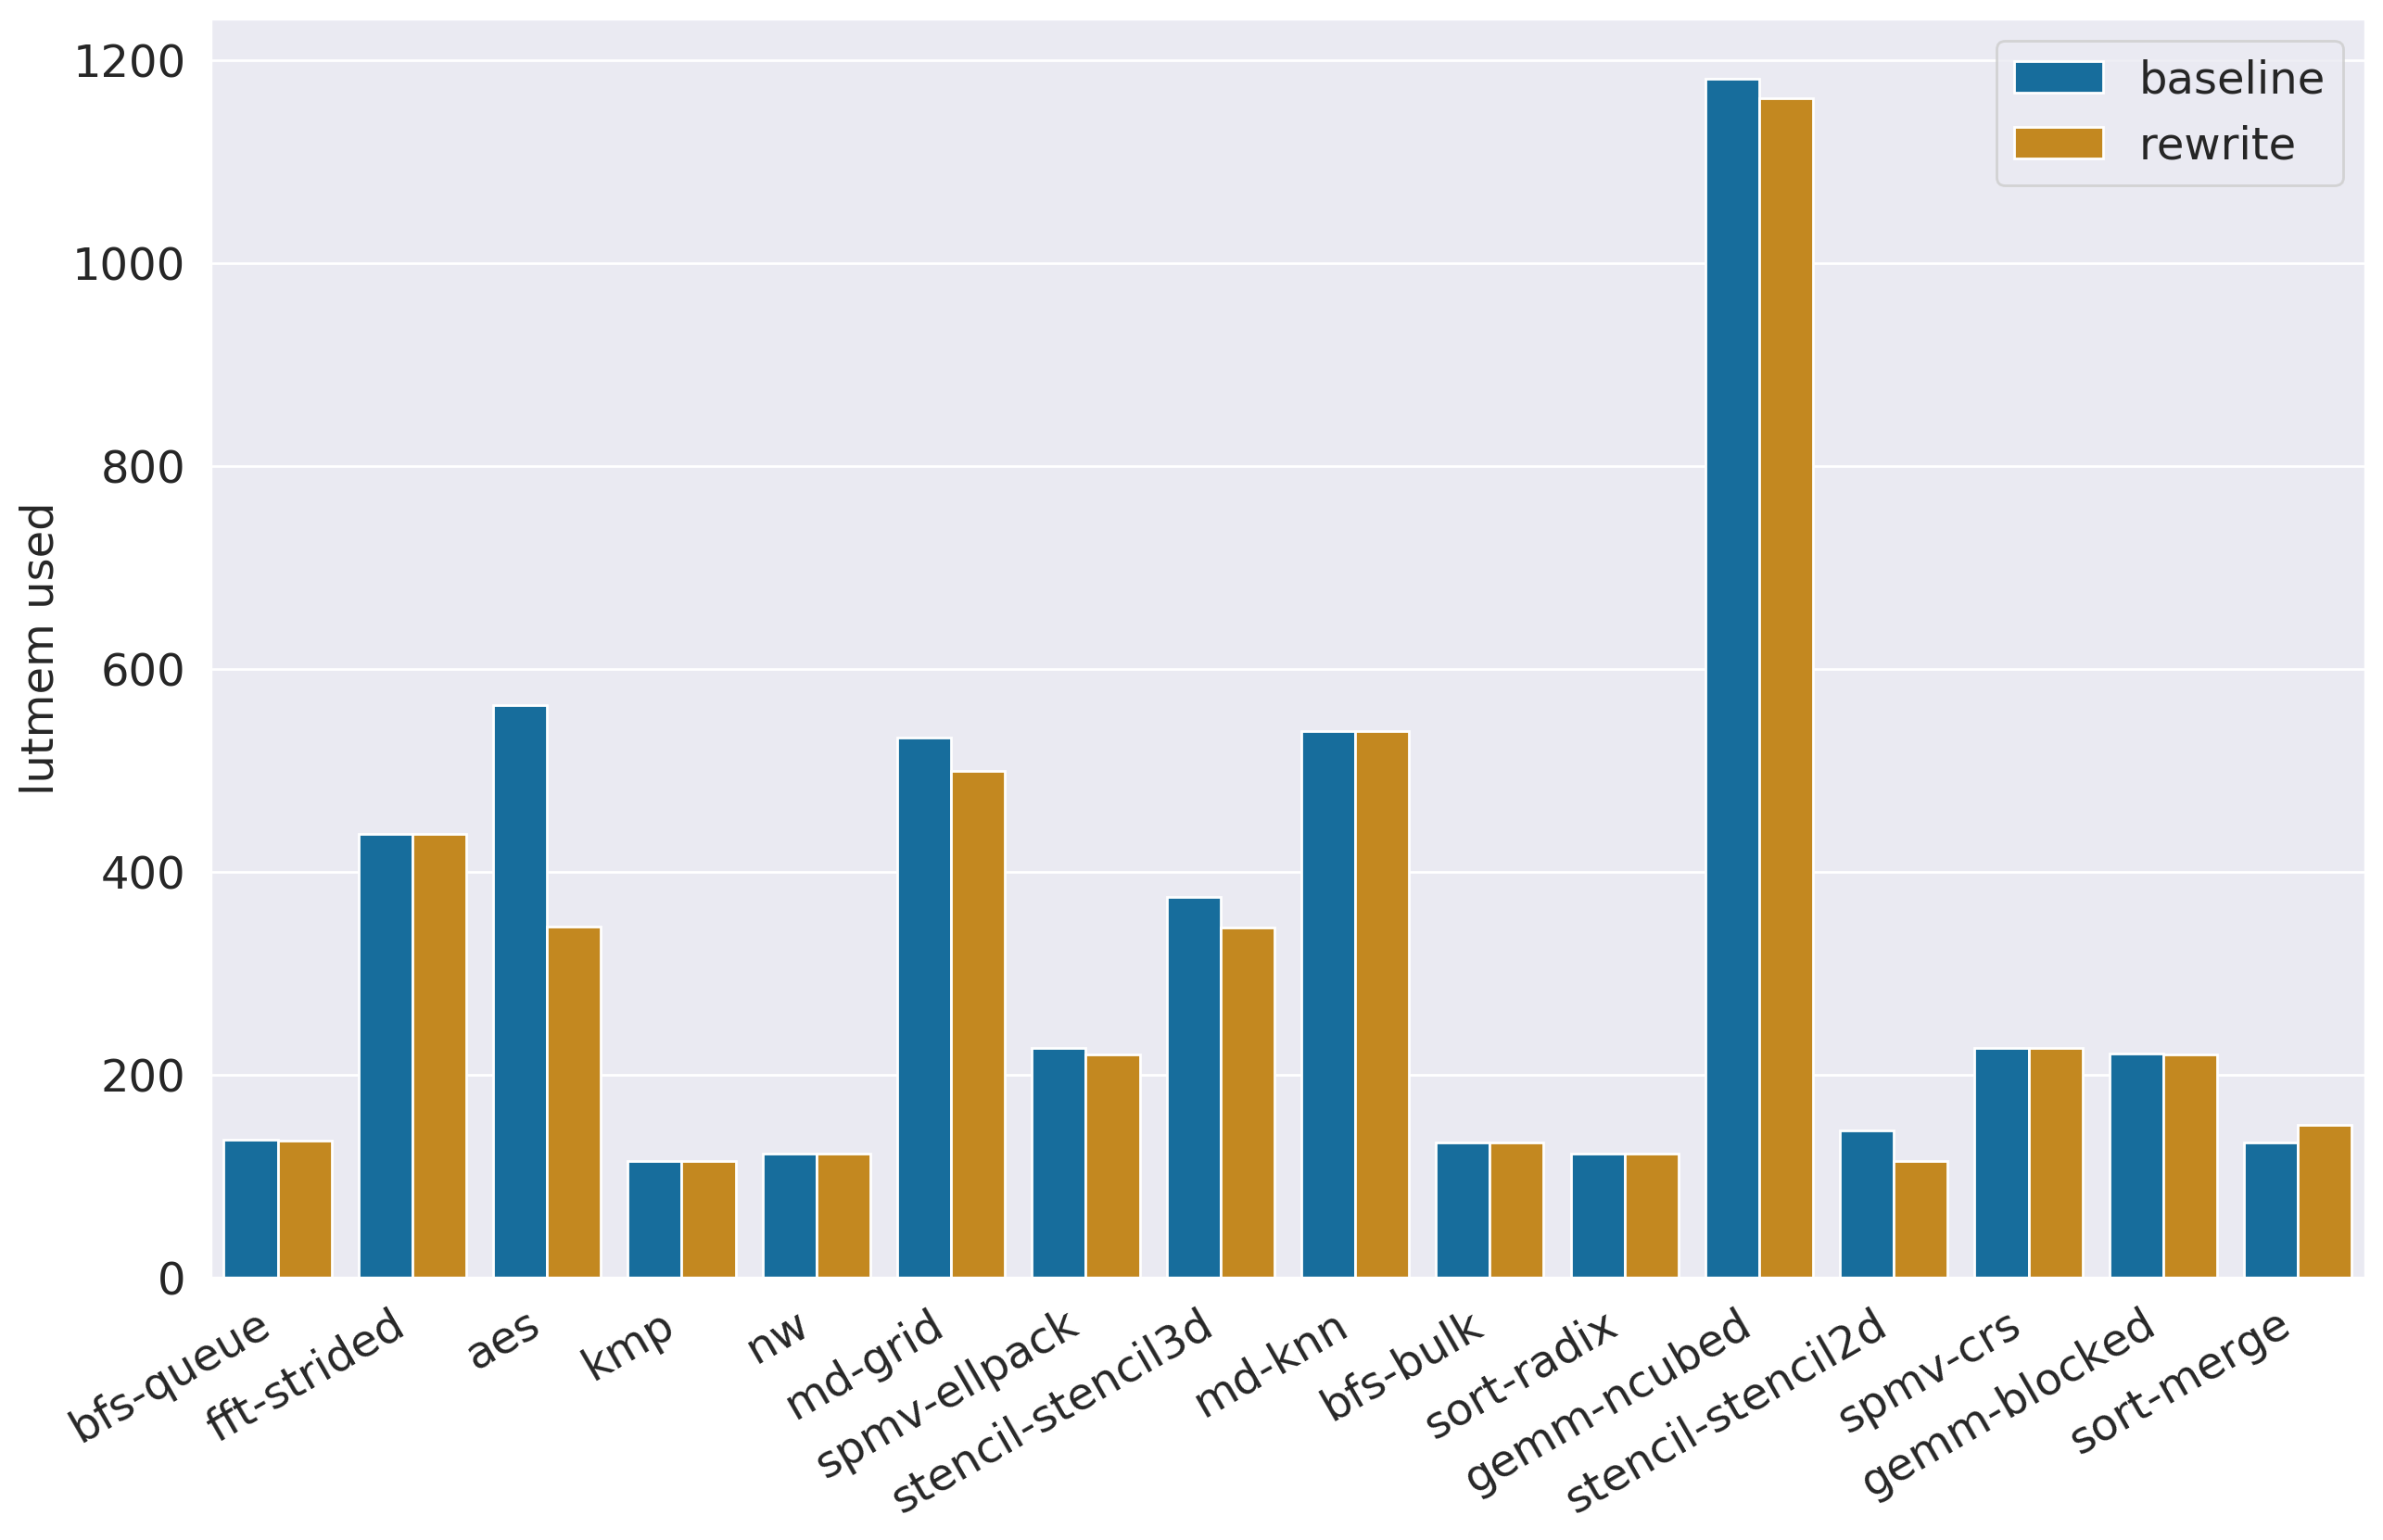

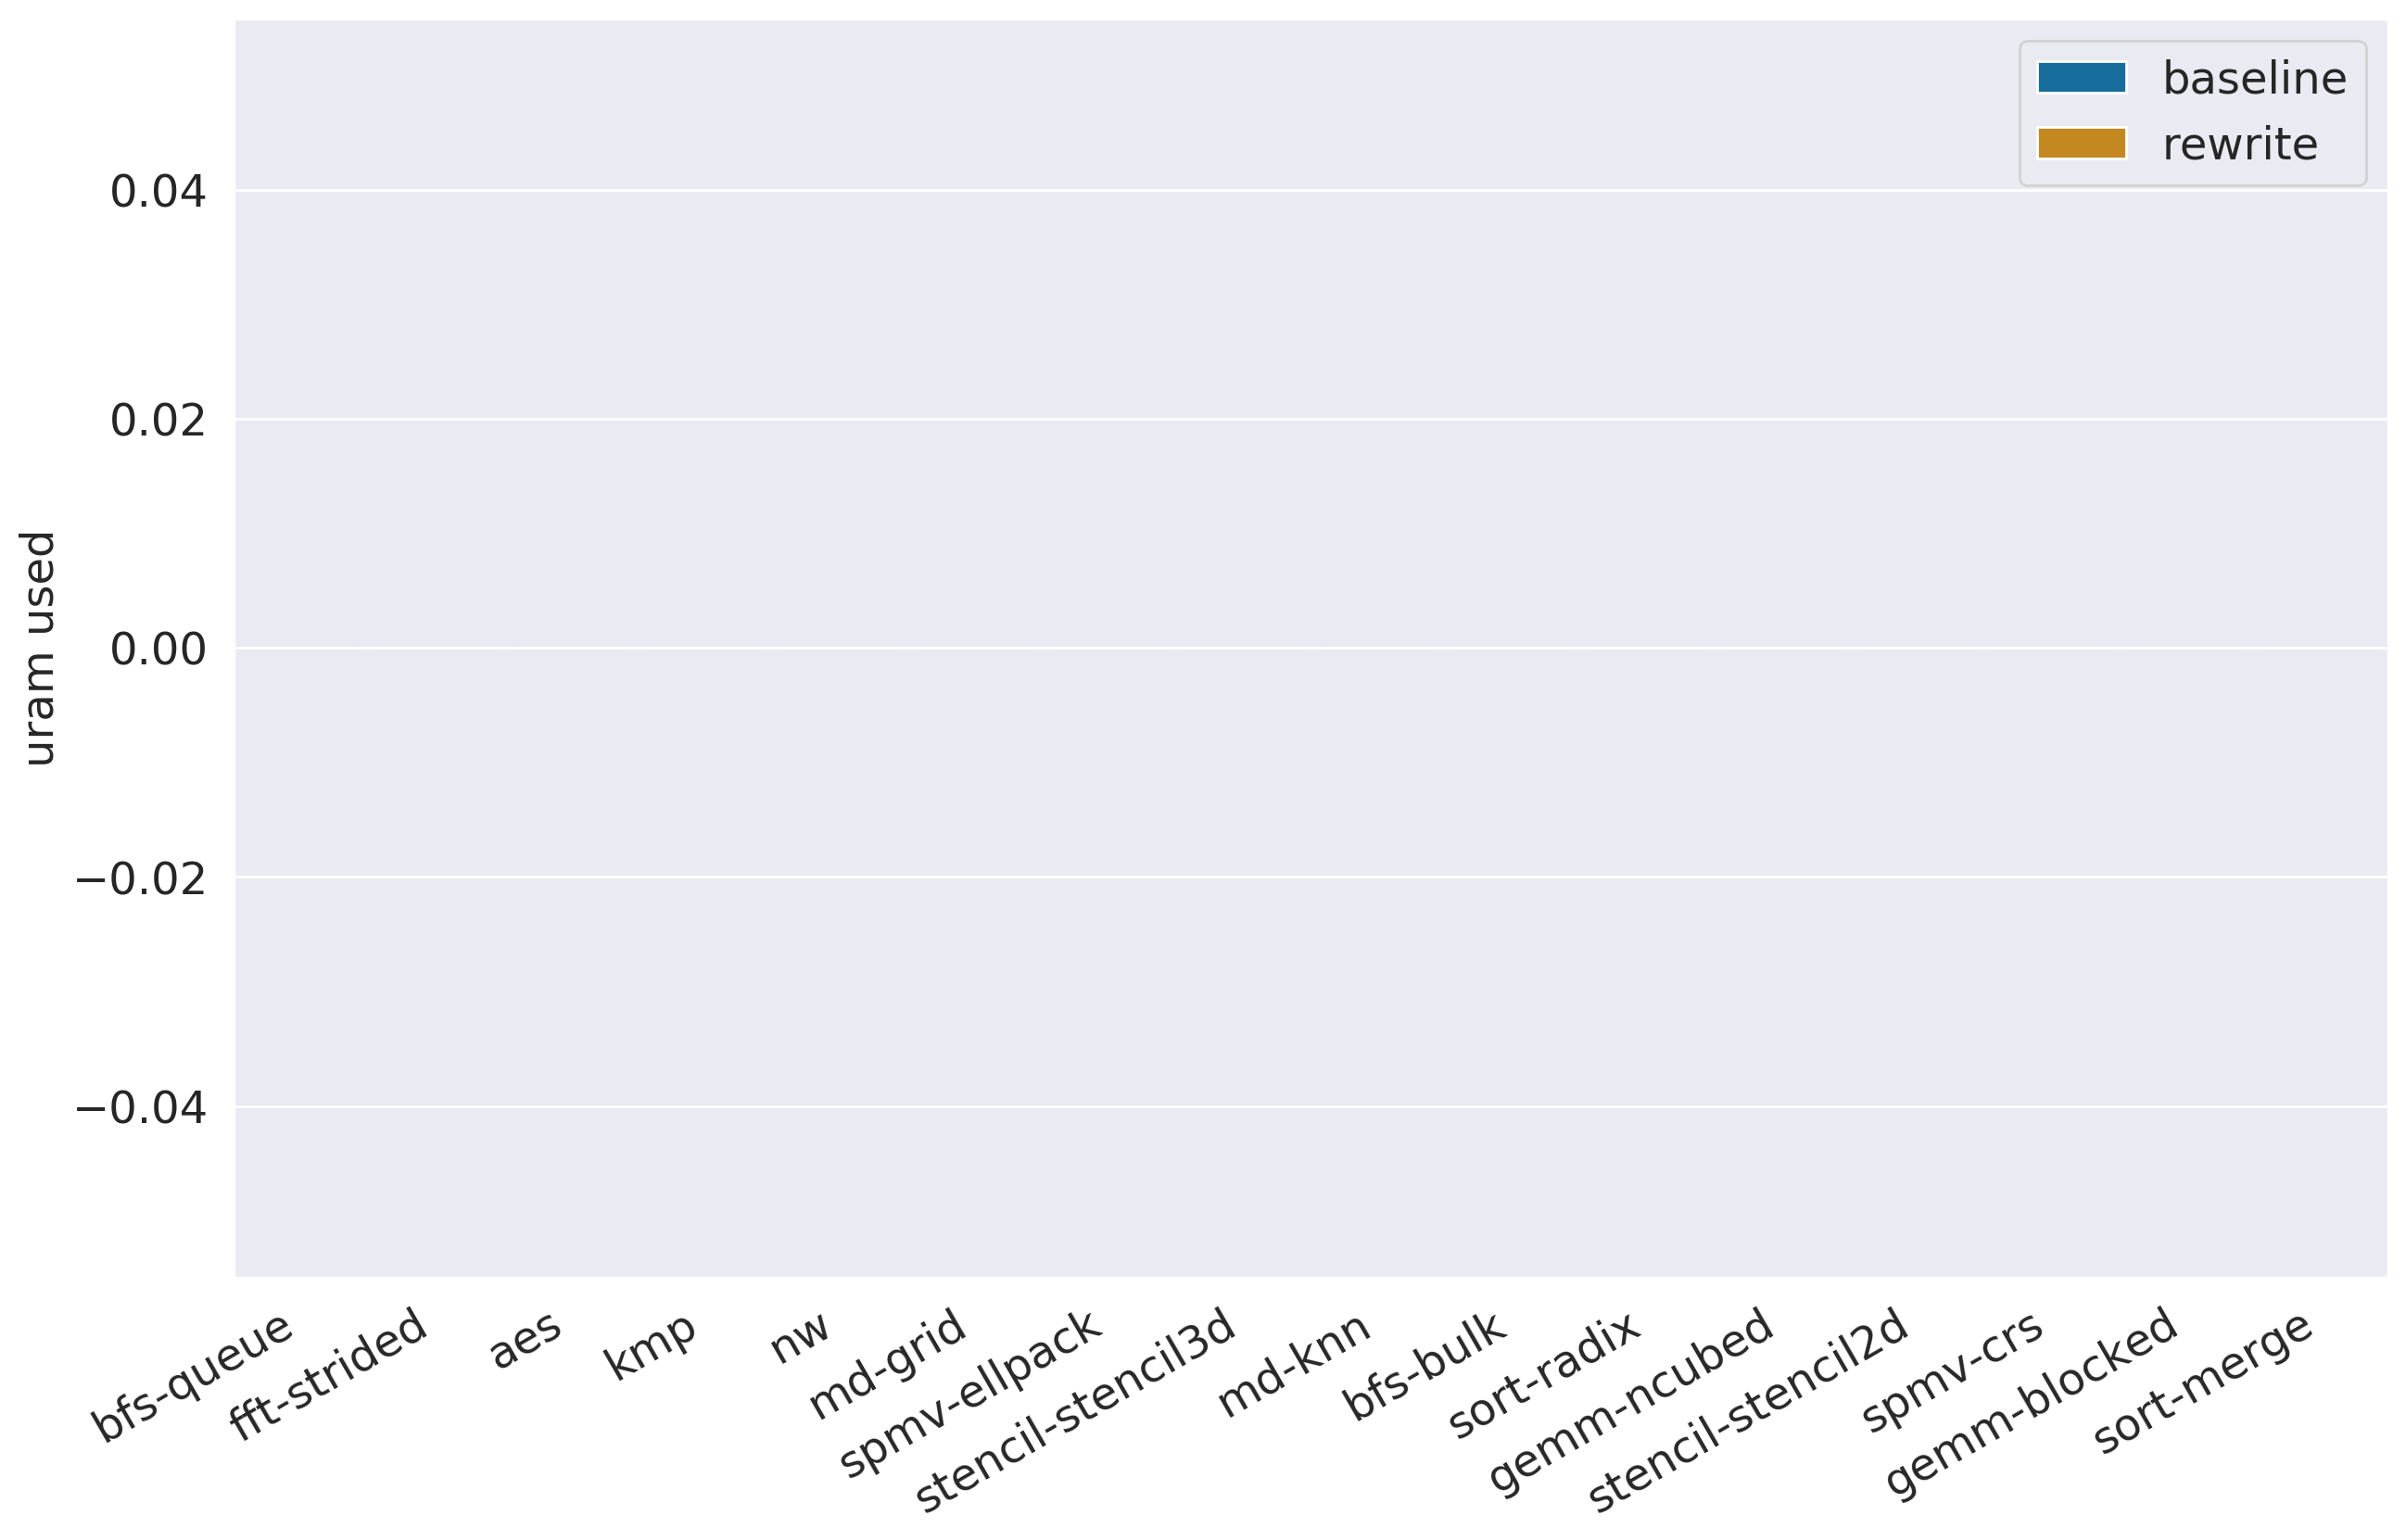

In [51]:
sns.set()

# Configuration for subplot
cols = 2
rows = int(math.ceil(len(keys) / cols))
# pal = sns.color_palette('colorblind', 8).as_hex()

# allfig, axes = plt.subplots(rows, cols, figsize=(14, 14), sharex=True)

for idx, key in enumerate(keys):
    # Get current axes for the subplot
#     all_ax = axes[int(idx / cols), idx % cols]
#     sns.barplot(x='bench', y=key, hue='type', data=df, ax=all_ax, palette='colorblind')
#     [ t.set_color('red') for t in all_ax.xaxis.get_ticklabels() if t.get_text() in rewrite_missing ]
#     all_ax.tick_params(labelrotation=90, axis='x')
    
    # also plot the graph to it's own figure
    fig, ax = plt.subplots(1, 1, figsize=(15, 9), dpi=200)
    sns.barplot(x='bench', y=key, hue='type', data=df, ax=ax, palette='colorblind')
    plt.legend(fontsize='x-large')
#     ax.tick_params(labelrotation=30, axis='x', labelsize=14, horizontalalignment='right')
    plt.xticks(rotation=30, horizontalalignment='right', fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.xlabel('')
    plt.ylabel(f'{key}'.replace('_', ' '), fontsize='x-large')
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30, size=16, horizontalalignment='right')
    fig.savefig(f'{key}.pdf', dpi=200, bbox_inches = "tight")

# title = 'Machsuite Benchmark (Absolute)'
# if len(baseline_missing) != 0:
#     title += ' [ missing: ' + ', '.join(list(baseline_missing)) + ' ]'
    
# allfig.suptitle(title, y=0.93)

In [9]:
allfig.savefig('absolute.png', dpi=300)

In [9]:
# Create join with baseline and rewrite data.
df_norm = df_rewrite.set_index('bench').join(df_baseline.set_index('bench'), lsuffix='_rewrite', rsuffix='_baseline')
for key in keys:
    df_norm[key] = df_norm[key + '_rewrite'] / df_norm[key + '_baseline']

df_norm.reset_index(inplace=True)
df_norm.fillna(value=0, inplace=True)

Text(0.5, -0.02, 'Machsuite Benchmark (Normalized) [ missing: viterbi, fft-transpose, backprop, sort-radix, aes, fft-strided ]')

<Figure size 432x288 with 0 Axes>

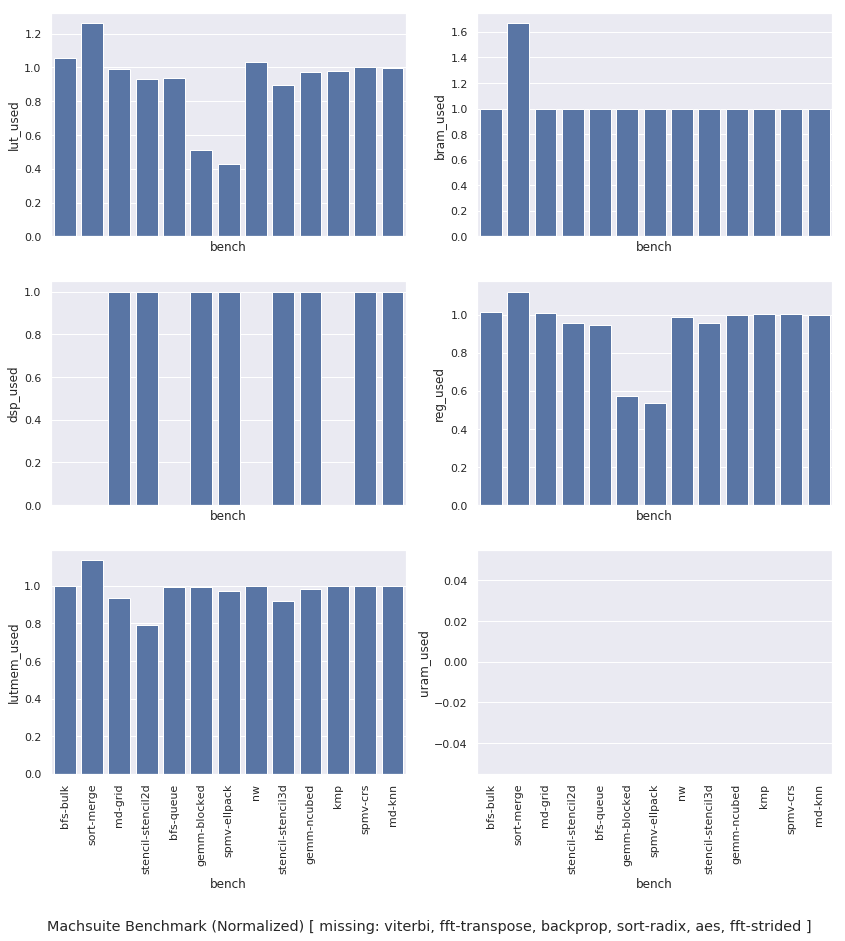

In [10]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(math.ceil(len(keys) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 14), sharex=True)

for idx, key in enumerate(keys):
    # Get current axes for the subplot
    ax = axes[int(idx / cols), idx % cols]
    sns.barplot(x='bench', y=key, data=df_norm, ax=ax, color=sns.color_palette()[0])
    ax.tick_params(labelrotation=90, axis='x')

title = 'Machsuite Benchmark (Normalized)'
missing = list(baseline_missing) + list(rewrite_missing)
if len(missing) != 0:
    title += ' [ missing: ' + ', '.join(missing) + ' ]'
    
fig.suptitle(title, y=0.93)

In [11]:
fig.savefig('normalized.png', dpi=300)